In [158]:
# Importar bibliotecas
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from google.colab import drive
import torch.optim as optim
import torch.nn as nn
import random
import torch
import os

In [159]:
# Importando dados do Kaggle
!curl -L -o /content/neural-networks-homer-and-bart-classification.zip https://www.kaggle.com/api/v1/datasets/download/juniorbueno/neural-networks-homer-and-bart-classification

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8248k  100 8248k    0     0  16.9M      0 --:--:-- --:--:-- --:--:-- 16.9M


In [160]:
# Extraindo arquivos
!unzip /content/neural-networks-homer-and-bart-classification.zip -d /content/neural-networks

Archive:  /content/neural-networks-homer-and-bart-classification.zip
  inflating: /content/neural-networks/homer_bart_1/bart1.bmp  
  inflating: /content/neural-networks/homer_bart_1/bart10.bmp  
  inflating: /content/neural-networks/homer_bart_1/bart100.bmp  
  inflating: /content/neural-networks/homer_bart_1/bart101.bmp  
  inflating: /content/neural-networks/homer_bart_1/bart102.bmp  
  inflating: /content/neural-networks/homer_bart_1/bart103.bmp  
  inflating: /content/neural-networks/homer_bart_1/bart104.bmp  
  inflating: /content/neural-networks/homer_bart_1/bart105.bmp  
  inflating: /content/neural-networks/homer_bart_1/bart106.bmp  
  inflating: /content/neural-networks/homer_bart_1/bart108.bmp  
  inflating: /content/neural-networks/homer_bart_1/bart109.bmp  
  inflating: /content/neural-networks/homer_bart_1/bart11.bmp  
  inflating: /content/neural-networks/homer_bart_1/bart110.bmp  
  inflating: /content/neural-networks/homer_bart_1/bart111.bmp  
  inflating: /content/neu

In [161]:
# Criando pastas para dividir os dados já que vieram todos juntos
!mkdir /content/neural-networks/homer
!mkdir /content/neural-networks/bart

mkdir: cannot create directory ‘/content/neural-networks/homer’: File exists
mkdir: cannot create directory ‘/content/neural-networks/bart’: File exists


In [162]:
# Verificando se as pastas foram criadas corretamente
!ls /content/neural-networks

bart  homer  homer_bart_1


In [163]:
# Movendo as imagens para as pastas corretas
!mv /content/neural-networks/homer_bart_1/bart* /content/neural-networks/bart/
!mv /content/neural-networks/homer_bart_1/homer* /content/neural-networks/homer/

# Removendo homer_bart_1
!rmdir /content/neural-networks/homer_bart_1

 transforms.RandomHorizontalFlip(p=0.5),                # Espelhar horizontalmente
    transforms.RandomRotation(degrees=15),                 # Rotação aleatória
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Alterar brilho/contraste

In [164]:
data_dir = '/content/neural-networks'

# Transformações para pré-processamento das imagens
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),           # Converter para escala de cinza
    transforms.RandomHorizontalFlip(p=0.5),                # Espelhar horizontalmente
    transforms.RandomRotation(degrees=15),                 # Rotação aleatória
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Alterar brilho/contraste
    transforms.Resize((64, 64)),                           # Redimensionar
    transforms.ToTensor(),                                 # Converter para tensor
    transforms.Normalize((0.5,), (0.5,))                   # Normalizar
])

# Carregar o conjunto de dados
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [165]:
# Dividir em treino (80%) e teste (20%)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Criar DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [166]:
# Classes
print("Classes:", dataset.classes)

# Verificar se os dados foram carregados corretamente
for images, labels in train_loader:
    print(f"Lote de imagens: {images.shape}")
    print(f"Lote de labels: {labels.shape}")
    break

Classes: ['bart', 'homer']
Lote de imagens: torch.Size([16, 1, 64, 64])
Lote de labels: torch.Size([16])


In [167]:
# Definir a rede neural
class SimpsonsNetImproved(nn.Module):
    def __init__(self):
        super(SimpsonsNetImproved, self).__init__()
        self.layer1 = nn.Linear(64 * 64, 1568)
        self.layer2 = nn.Linear(1568, 3136)
        self.layer3 = nn.Linear(3136, 1568)
        self.layer3_4 = nn.Linear(1568, 1568)
        self.layer4 = nn.Linear(1568, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = x.view(-1, 64*64)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.layer4(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# Instanciar o modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpsonsNetImproved().to(device)

# Otimizador e função de perda
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

print(model)

SimpsonsNetImproved(
  (layer1): Linear(in_features=4096, out_features=1568, bias=True)
  (layer2): Linear(in_features=1568, out_features=3136, bias=True)
  (layer3): Linear(in_features=3136, out_features=1568, bias=True)
  (layer3_4): Linear(in_features=1568, out_features=1568, bias=True)
  (layer4): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [168]:
# Função de treinamento
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)

In [169]:
# Função de teste
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, accuracy


Iniciando a época 1...
Época 1 - Average loss: 0.6695 - Accuracy: 61.11%)

Iniciando a época 2...
Época 2 - Average loss: 0.6655 - Accuracy: 62.96%)

Iniciando a época 3...
Época 3 - Average loss: 0.6211 - Accuracy: 64.81%)

Iniciando a época 4...
Época 4 - Average loss: 0.5817 - Accuracy: 62.96%)

Iniciando a época 5...
Época 5 - Average loss: 0.5225 - Accuracy: 72.22%)

Iniciando a época 6...
Época 6 - Average loss: 0.5026 - Accuracy: 66.67%)

Iniciando a época 7...
Época 7 - Average loss: 0.7367 - Accuracy: 61.11%)

Iniciando a época 8...
Época 8 - Average loss: 0.5908 - Accuracy: 66.67%)

Iniciando a época 9...
Época 9 - Average loss: 0.5638 - Accuracy: 70.37%)

Iniciando a época 10...
Época 10 - Average loss: 0.5251 - Accuracy: 66.67%)

Iniciando a época 11...
Época 11 - Average loss: 0.4696 - Accuracy: 75.93%)

Iniciando a época 12...
Época 12 - Average loss: 0.5404 - Accuracy: 68.52%)

Iniciando a época 13...
Época 13 - Average loss: 0.5648 - Accuracy: 74.07%)

Iniciando a époc

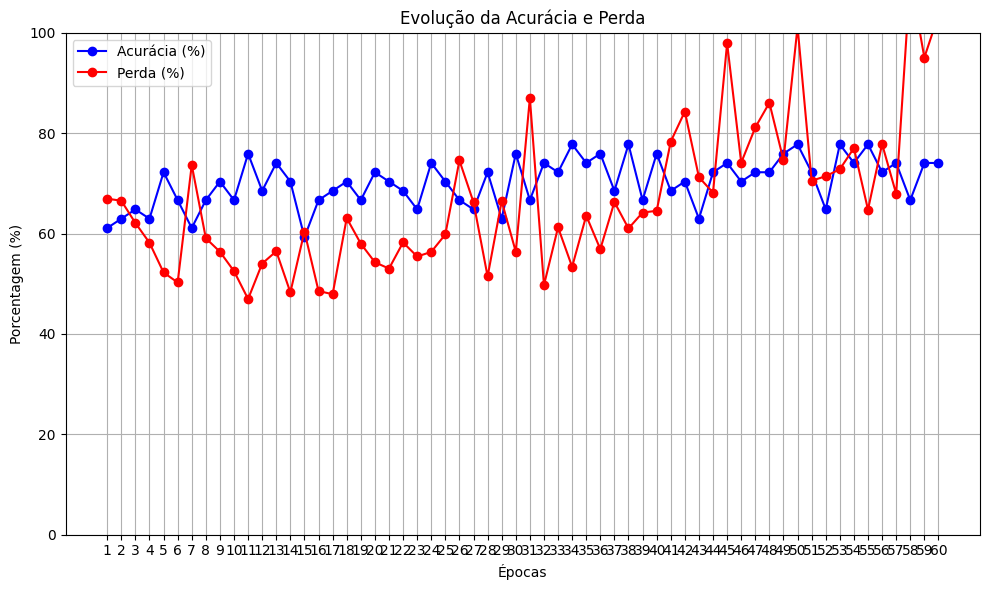

In [170]:
# Armazenando as métricas de treino e teste para gráficos
train_losses = []
test_losses = []
accuracies = []

# Laço de treinamento
epochs = 60
for epoch in range(1, epochs + 1):
    print(f'\nIniciando a época {epoch}...')
    train_loss = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, accuracy = test(model, device, test_loader, criterion)

    # Exibir o resultado da época
    print(f'Época {epoch} - Average loss: {test_loss:.4f} - Accuracy: {accuracy:.2f}%)')

    # Armazenar os resultados
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

# Convertendo perdas para porcentagem
test_losses_percentage = [loss * 100 for loss in test_losses]

# Gerar o gráfico combinado
plt.figure(figsize=(10, 6))

# Plotar acurácia
plt.plot(range(1, epochs + 1), accuracies, marker='o', color='b', label='Acurácia (%)')

# Plotar perda (em %)
plt.plot(range(1, epochs + 1), test_losses_percentage, marker='o', color='r', label='Perda (%)')

# Configurações do gráfico
plt.title('Evolução da Acurácia e Perda')
plt.xlabel('Épocas')
plt.ylabel('Porcentagem (%)')
plt.xticks(range(1, epochs + 1))
plt.ylim(0, 100)
plt.grid(True)
plt.legend()

# Exibir o gráfico
plt.tight_layout()
plt.show()

Professor, durante o desenvolvimento desse modelo, tentei aplicar tudo o que consegui absorver das aulas, fazendo as seguintres modificações:

1. incluir pré-processamentos como rotação, espelhamento e alteração de brilho e contraste
2. Mudar o tamanho do batch_size para 8, 16, 32 e 64
3. Aumentar ou diminuir a quantiade de camadas e neuronios
4. Testar outros optimizadores como adam, SGD e afins
5. Alterar o valor de learning rate de 0.1 até 0.00001
6. Alterar o numero de épocas de 5 até 60 épocas

Mesmo com ajuda de materiais e até o chatgpt, não consegui resolver esse modelo.